## Cats and Dogs 이진 분류
### 이진 분류 프로젝트

#### 개요
- 목표 : CNN으로 개와 고양이 이미지 분류 이진 분류기

#### Kaggle 데이터 다운로드
- 캐글이 뭐예요?
    - https://www.kaggle.com/
    - 예측모델 및 분석 대회 플랫폼. 2017년 구글이 인수

1. Kaggle 계정 만들기
2. 설정 진입
    - https://www.kaggle.com/settings
    - API > Create New Token 클릭 kaggle.json 다운로드

3. 파이썬 Kaggle 패키지 설치
```shell
    !pip install kaggle
```

4. kaggle.json 파일 위치
    - 리눅스/유닉스 : ~/.kaggle/kaggle.json
    - 윈도우 : %USERPROFILE%\.kaggle
        - 사용자 폴더 아래
    - 다운로드 받은 kaggle.json을 붙여넣기

5. https://www.kaggle.com/competitions/dogs-vs-cats/overview 진입
    - Data 탭에서 Join the competition 버튼 클릭

In [1]:
!pip install kaggle


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 데이터셋 다운로드
!kaggle competitions download -c dogs-vs-cats

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Source\iot-dataanalysis-2025\mlvenv\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Source\iot-dataanalysis-2025\mlvenv\Lib\site-packages\kaggle\__init__.py", line 6, in <module>
    api.authenticate()
  File "C:\Source\iot-dataanalysis-2025\mlvenv\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Admin\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


#### 데이터셋 전처리

In [3]:
# 파이썬 모듈로드
import os, shutil, random

In [4]:
# 500개씩 샘플링 함수
def sample_data(src_dir, dst_dir, num_samples=500):
    os.makedirs(dst_dir, exist_ok=True) # 폴더 생성, exist_ok = True 이미 존재하면 만들지 않음
    all_files = [f for f in os.listdir(src_dir) if f.startswith(dst_dir.split('/')[-1])]
    samples = random.sample(all_files, num_samples)
    for f in samples:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

In [5]:
# 폴더 정리
base_dir = './data/train' # 원본폴더 25000개
cat_dir = './data/sample/cat'
dog_dir = './data/sample/dog'

In [6]:
os.makedirs('./data/sample/cat', exist_ok=True)
os.makedirs('./data/sample/dog', exist_ok=True)

In [7]:
# sample_data() 함수 사용
sample_data(base_dir, cat_dir, 500)
sample_data(base_dir, dog_dir, 500)

<img src='../image/ml19.png' width='700'>

#### 파이토치 시작!
- ImageFolder 클래스 - 폴더명을 자동으로 레이블로 변환
    - cat -> 0, dog -> 1

In [8]:
# 파이토치 모듈 로드
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [10]:
train_dataset = ImageFolder('./data/sample', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### train_loader 시각화

In [11]:
# 시각화용 모듈 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
# 한글로 Matplotlib 사용시 항상 필요
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [13]:
# 배치하나 꺼내기
images, labels = next(iter(train_loader))

In [14]:
images[0].shape

torch.Size([3, 128, 128])

In [15]:
class_names = ['cat', 'dog']

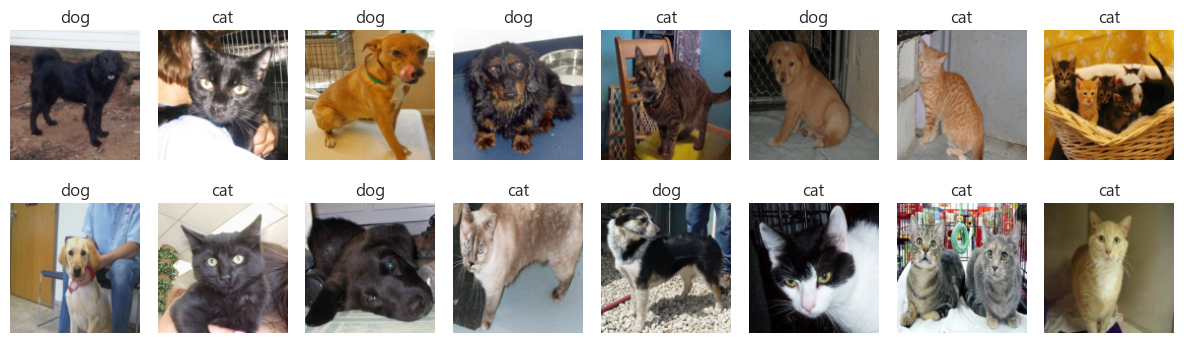

In [16]:
# 시각화
plt.figure(figsize=(12, 4))
for i in range(16): # 32 중 반만 표현
    plt.subplot(2, 8, i+1)

    img = images[i].permute(1, 2, 0) # 컬러채널이기 때문에 matplotlib 표현 시 순서 병경
    plt.imshow(img)
    plt.title(f'{class_names[labels[i].item()]}')
    plt.axis('off')

    plt.tight_layout()

#### CNN 모델 정의

In [17]:
# 사용모듈 로드
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# 클래스 정의
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # conv1, conv2 모두 사용
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128) # MaxPool(128) -> MaxPool(64) -> 32x32
        self.fc2 = nn.Linear(128, 1) # 마지막 분류가 0, 1

    def forward(self, x):
        # conv -> activation -> maxpooling 2회 실시
        # dense1, 2 통과
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64* 32 * 32) # flatten -> 1차원 배열화, 65,536개 입력
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) # F.sigmoid() deprecated
        return x

#### 훈련

In [19]:
# cuda 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)

criterion = nn.BCELoss() # Binary Cross Entropy 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# 훈련함수 정의
def train(model, dataloader, criterion, optimizer):
    model.train() # 훈련모드
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1) # 1, 0 -> [1, ], [0, ]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [21]:
# 훈련
EPOCH = 10

for epoch in range(EPOCH):
    loss = train(model, train_loader, criterion, optimizer)

    print(f'[{epoch+1}/{EPOCH}] Loss: {loss:.4f}')

[1/10] Loss: 0.7014
[2/10] Loss: 0.6674
[3/10] Loss: 0.6289
[4/10] Loss: 0.5558
[5/10] Loss: 0.4633
[6/10] Loss: 0.3534
[7/10] Loss: 0.2468
[8/10] Loss: 0.1258
[9/10] Loss: 0.0528
[10/10] Loss: 0.0242


#### 예측결과 시각화

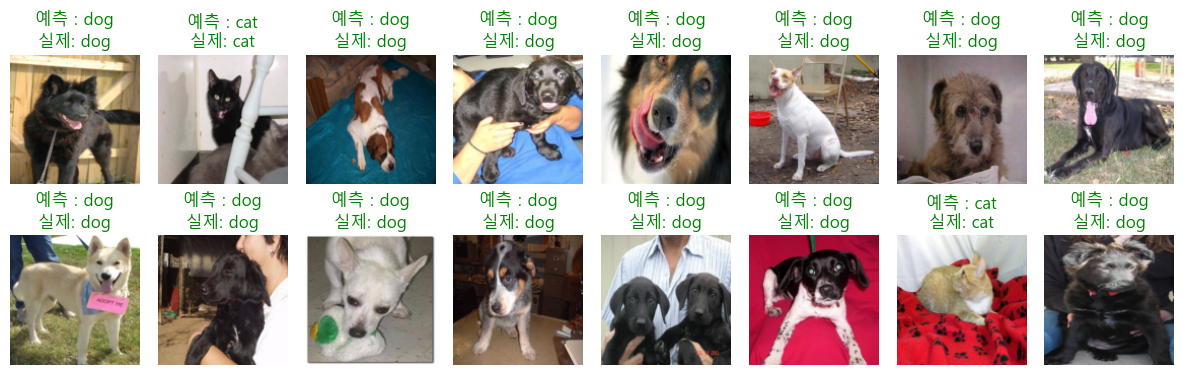

In [22]:
# 검증
model.eval()
images, labels = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).int().cpu().squeeze()

plt.figure(figsize=(12, 4))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(images[i].cpu().permute(1,2,0))
    pred_label = 'dog' if preds[i] == 1 else 'cat'
    true_label = 'dog' if labels[i] == 1 else 'cat'
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'예측 : {pred_label}\n실제: {true_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 모델저장 / 불러오기

In [23]:
# 가중치만 저장
torch.save(model.state_dict(), './catdog_weight.pth')

In [24]:
# 모델전체 저장
torch.save(model, './catdog_model.pth')

In [25]:
# 가중치만 불러올때
model2 = CatDogCNN().to(device)
model2.load_state_dict(torch.load('./catdog_weight.pth', map_location=device))
model2

CatDogCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

#### 테스트 이미지로 테스트
- 1.jpg ~ 12500.jpg 까지 Dog, Cat 구분

In [26]:
# 필요 모듈로드
import torch
from torchvision import transforms
from PIL import Image

In [27]:
# transform 위 선언

img = Image.open('./data/test1/1.jpg').convert('RGB')
img_tensor = transform(img).unsqueeze(0)  # [3, 128, 128] -> [1, 3, 128, 128] 4차원 텐서로 변경
# print(img_tensor)
img.show()  # 기본 이미지뷰 프로그램으로 표현

In [28]:
model.eval()   # 예측, 평가 모드로

with torch.no_grad():
    output = model(img_tensor.to(device))
    pred = (output > 0.5).int().item()

'Dog' if pred == 1 else 'Cat'

'Dog'

#### 폴더로 여러개 테스트

In [29]:
# 파이썬 모듈로드
import os, shutil, random

In [30]:
test_dir = './data/test1'
image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]

In [31]:

len(image_files)

12500

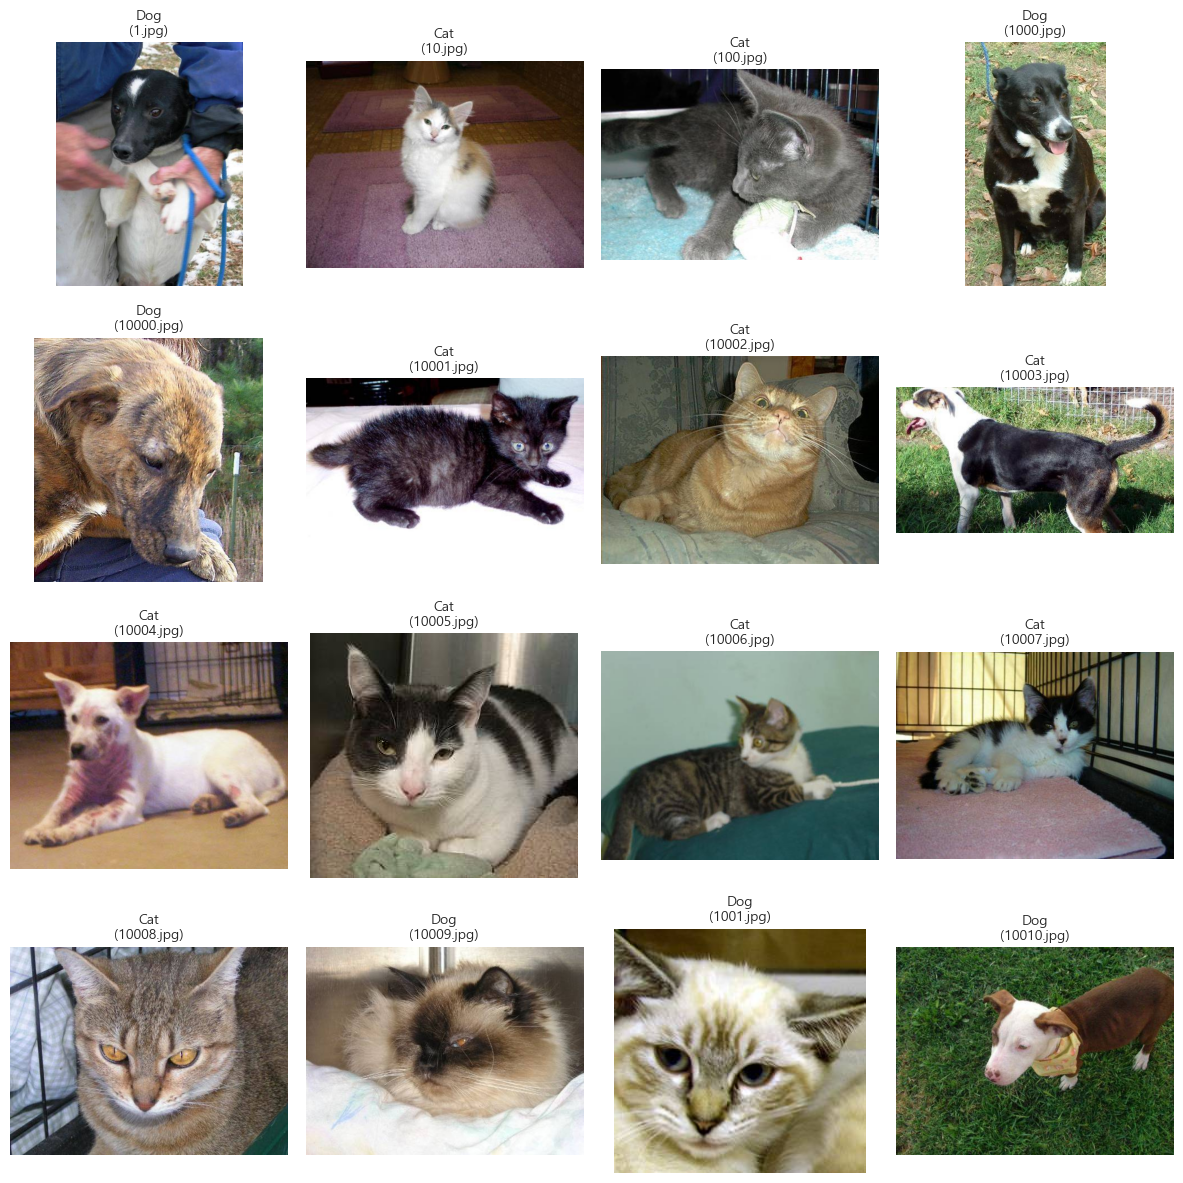

In [32]:
# 예측과 시각화 동시
plt.figure(figsize=(12, 12))
for i, fname in enumerate(image_files[0:16]):  # 최대 16장까지 출력 0:16, 16:32, 32:48
    img_path = os.path.join(test_dir, fname)
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = 'Dog' if output.item() > 0.5 else 'Cat'

    # 이미지 출력
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f'{pred}\n({fname})', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Kaggle Competitions 도전
- 캐글 상에선 경로 등이 윈도우와 다르기때문에 설정 변경이 필요

#### 캐글 순서
1. Data > Join the Competition 클릭
2. Code > New Notbook 클릭(코랩과 동일)
3. 노트북 작성
4. 캐글 서버내 압축파일 처리부분만 새로 코딩
5. 위의 소스 그대로 사용가능
6. submission.csv 만드는 코드 추가
7. submission.csv 제출

#### 캐글 GPU
- 캐글 노트북 Settings > Accelerator > GPU T4 x2, GPU P1000 으로 GPU 사용가능(1주 30시간 제한)